```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import pyopencl
import subprocess
import os
import StringIO

#Finally, import our simulator
from SWESimulators import FBL, CTCS, DataOutput

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "0"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz


In [3]:
def gen_reference(nx):
    csv_filename = 'swashes_1_nx=' + str(nx) + '.csv'

    #If we do not have the data, generate it    
    if (not os.path.isfile(csv_filename)):
        print "Generating new reference!"
        swashes_path = r'C:\Users\anbro\Documents\programs\SWASHES-1.03.00_win\bin\swashes_win.exe'

        swashes_args = [\
                        '1', # 1D problems \
                        '3', # Dam breaks \
                        '1', # Domain 1 \
                        '1', # Wet domain no friction
                        str(nx) #Number of cells X
                       ]

        with open(csv_filename, 'w') as csv_file:
            p = subprocess.check_call([swashes_path] + swashes_args, stdout=csv_file)

    reference = np.genfromtxt(csv_filename, comments='#', delimiter='\t', skip_header=0, usecols=(0, 1, 2))
    return reference

In [4]:
def gen_test_data(nx, num_ghost_cells):
    ny = 1
    dx = 10.0 / float(nx)
    dy = 1.0

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create dam break
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*i

            if (x < 5):
                h[j+num_ghost_cells, i+num_ghost_cells] = 0.005
            else:
                h[j+num_ghost_cells, i+num_ghost_cells] = 0.001
    
    return h, hu, hv, dx, dy, nx, ny

In [5]:
def run_benchmark(simulator, nx, courant_number, ghost_cells):
    
    h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ghost_cells)
    reference = gen_reference(nx)
    
    g = 9.81
    max_u = 0.13; #Estimate of maximum velocity
    dt = courant_number * dx / (max_u + np.sqrt(g*0.005))

    #Initialize simulator
    sim = simulator(cl_ctx,
                    h0, hu0, hv0, \
                    nx, ny, \
                    dx, dy, dt, \
                    g)

    t = sim.step(6.0)
    h1, hu1, hv1 = sim.download()

    x = reference[:,0]
    
    h_ref = reference[:,1]
    hu_ref = reference[:,1]*reference[:,2]
    
    h = h1[ghost_cells, ghost_cells:-ghost_cells]
    hu = hu1[ghost_cells, ghost_cells:-ghost_cells]
    
    error = np.linalg.norm(h_ref - h)*dx
    conservation = (np.sum(h_ref) - np.sum(h))*dx
    
    return x, h_ref, hu_ref, h, hu, error, conservation

In [6]:
def compute_convergence(simulator, ghost_cells, domain_sizes, plot=False):
    l2_error = np.zeros(len(domain_sizes))
    conservation = np.zeros(len(domain_sizes))

    for i, nx in enumerate(domain_sizes):
        x, h_ref, hu_ref, h, hu, err, cons = run_benchmark(simulator, nx, 0.5, ghost_cells)

        l2_error[i] = err
        conservation[i] = cons

        if (plot):
            plt.plot(x, h_ref)
            plt.plot(x, h, label=['nx=', str(nx)])
                        
    return conservation, l2_error

LxF


C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\pyopencl\__init__.py:59: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz' on 'Intel(R) OpenCL' at 0x303a50> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <swe_2D> was successfully vectorized
Done.
  warn(text, CompilerWarning)


[ -2.48479325e-05  -8.93932327e-06  -1.58885575e-05  -1.52252608e-05
   1.49526689e-05  -2.54560828e-08]
FORCE
[ -2.48502608e-05  -8.93932327e-06  -1.58862292e-05  -1.52229325e-05
   1.49526689e-05  -2.31277764e-08]
HLL
[ -2.48502608e-05  -8.93932327e-06  -1.58839009e-05  -1.52252608e-05
   1.49526689e-05  -2.54560828e-08]
HLL2
[ -2.48502608e-05  -8.93932327e-06  -1.58862292e-05  -1.52252608e-05
   1.49526689e-05  -2.54560828e-08]
WAF
[ -2.48502608e-05  -8.93932327e-06  -1.58839009e-05  -1.52229325e-05
   1.49526689e-05  -2.54560828e-08]
KP07
[ -2.48502608e-05  -8.93932327e-06  -1.58862292e-05  -1.52252608e-05
   1.49526689e-05  -2.54560828e-08]


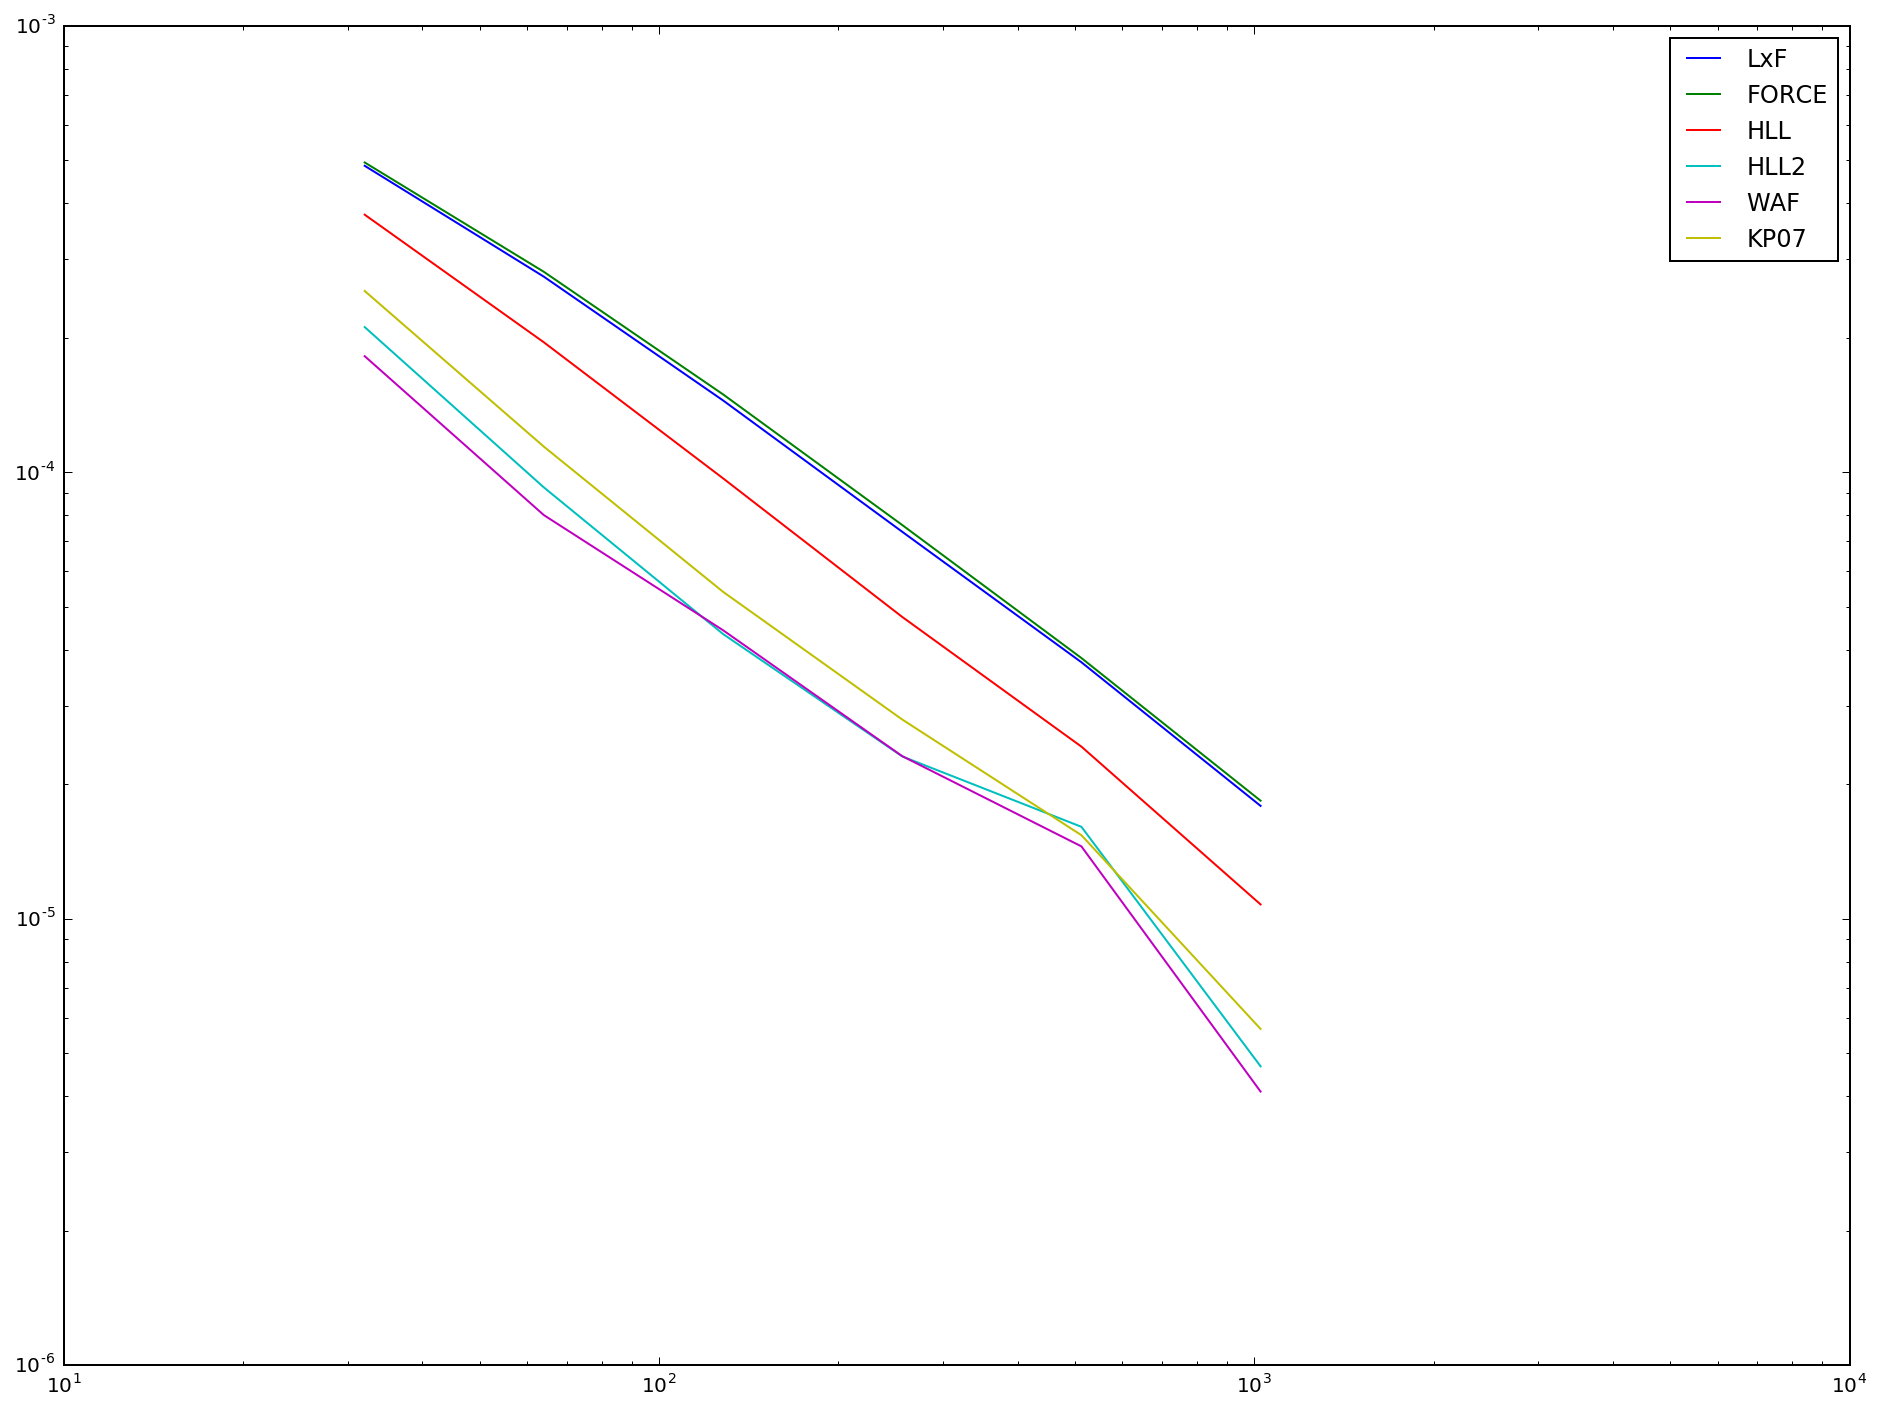

In [7]:
domain_sizes = [32, 64, 128, 256, 512, 1024]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07']

plt.figure()
for i in range(len(simulators)):
    print simulator_names[i]
    conservation, l2_error = compute_convergence(simulators[i], simulator_ghost_cells[i], domain_sizes)
    print conservation
    plt.loglog(domain_sizes, l2_error, label=simulator_names[i])
plt.legend()